In [1]:
import msprime
import pyslim
import tskit
import numpy as np
# import sparg
import random
from IPython.display import SVG
import matplotlib.pyplot as plt #plotting
import pandas as pd

### **Loading the tree sequence**

In [2]:
ts = tskit.load("C:/Users/Hp/linuxpc-shared/arabidopsis-test3/rts.trees")
rts = ts
rts = pyslim.update(rts)
# rts = pyslim.recapitate(ts, recombination_rate=8e-10, ancestral_Ne=5000)
rts

C:\Users\Hp\anaconda3\envs\slendr\lib\site-packages\pyslim\slim_metadata.py:936: UserWarning: This is a version 0.7 SLiM tree sequence. When you write this out, it will be converted to version 0.8.
  warnings.warn("This is a version {} SLiM tree sequence.".format(file_version) +


In [3]:
orig_max_roots = max(t.num_roots for t in ts.trees())
recap_max_roots = max(t.num_roots for t in rts.trees())
print(f"Maximum number of roots before recapitation: {orig_max_roots}\n"
      f"After recapitation: {recap_max_roots}")

Maximum number of roots before recapitation: 1
After recapitation: 1


In [4]:
indivs = pyslim.individuals_alive_at(rts, 0)
len(indivs)

42841

### **Simplifying the tree sequence**

In [5]:
samples = random.sample(sorted(indivs), 15) # randomly choosing individuals to sample from the tree sequence

In [6]:
sts = rts.simplify(samples=samples, keep_input_roots=True)

In [7]:
sts

### **Preparing the tree sequence for plotting**
#### Adapted from the space-trees notebook by Esther, Pam, Matt, 

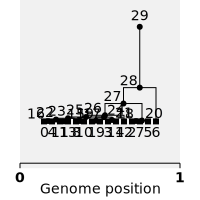

In [8]:
SVG(sts.draw_svg()) # drawing the tree sequence

╔═════════════════════════════╗
║Tree                         ║
╠═══════════════════╤═════════╣
║Index              │        0║
╟───────────────────┼─────────╢
║Interval           │  0-1 (1)║
╟───────────────────┼─────────╢
║Roots              │        1║
╟───────────────────┼─────────╢
║Nodes              │       30║
╟───────────────────┼─────────╢
║Sites              │        0║
╟───────────────────┼─────────╢
║Mutations          │        0║
╟───────────────────┼─────────╢
║Total Branch Length│244928.16║
╚═══════════════════╧═════════╝



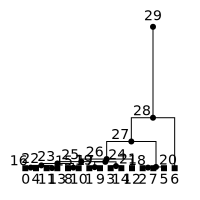

In [9]:
tree0 = sts.at_index(0) # let's look at the very first tree
print(tree0) # get some more info about this tree
SVG(tree0.draw_svg()) # display the tree

In [10]:
[sts.node(sample).id for sample in tree0.samples()]

[6, 5, 2, 7, 12, 8, 10, 11, 13, 0, 4, 1, 9, 3, 14]

To plot parent-child relationships, we need to keep track of the lineages of all of the individuals alive at present day. Specifically, we need to keep track of the lineages of all _sample nodes_ at a given locus, because the ancestry can be different depending on which locus we're talking about. The following code traverses through the tree, node by node, and keeps track of all of the individuals the nodes belong to. 

In [11]:
samps = tree0.samples() #retrieve all samples in the tree
root_t = sts.node(tree0.root).time #find how many generations ago the root existed

list_of_nodes = []
dict_of_inds = {}
    
for i in samps:
    
    nodes = []
    inds = []
    
    samp_node = sts.node(i).id #find the node id of the sample in question
    nodes.append(samp_node) #add it to the list of nodes
    ind = sts.node(i).individual #find the individual this sample node is in
    inds.append(ind) #add it to the list of individuals
    
    parent = tree0.parent(i) #find the parent node of the sample node in question
    nodes.append(parent) #add it to the list of nodes
    p_ind = sts.node(parent).individual #find the individual that parent node is in
    inds.append(p_ind) #add it to the list of individuals
    
    t = sts.node(parent).time #find how many generations ago the parent existed
    
    while t < root_t: #Ensure we find parents of parents until we hit the root
        parent = tree0.parent(parent) #overwrite the parent variable to its parent
        nodes.append(parent) #add it to the list of nodes
        p_ind = sts.node(parent).individual #find the individual that parent node is in
        inds.append(p_ind) #add it to the list of individuals
                 
        t = sts.node(parent).time #overwrite the t variable to the time of the parent's parent
        
    list_of_nodes.append(nodes)
    dict_of_inds[inds[0]] = inds
        
# print (list_of_nodes) # You can uncomment this to see the list of ancestral nodes for each sample
# print (list_of_inds)

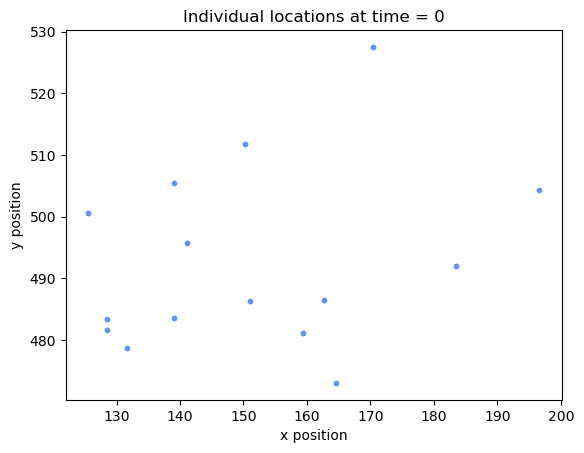

In [12]:
#First, we need to define our plot and the groups that we want to work with:
figure1 = plt.figure()
time = 0 #choose the desired time step (we will use time = 0, or 0 time steps ago)
alive = pyslim.individuals_alive_at(sts, time) #all individuals alive at time (defined above)
locs = sts.individual_locations[alive] #the locations of individuals from alive 

#Next, set up the x-y coordinates for our chosen individuals:
x=locs[:, 0] #x-axis values of plot using locs
y=locs[:, 1] #y-axis values of plot using locs

#Generate the scatter plot:
plt.scatter(x, y, color= 'cornflowerblue', marker= 'o', s=10)
#this function generates a scatter plot, and we can add some customizations:
#customize color with "color = __" or c = "xkcd:____"; e.g. c="xkcd:cornflower blue" or color="cornflowerblue"
#customize shape of points with "marker = <shape of points>" (* = stars!)
#customize size of points with "s = <size of point>"

#Finally, add some labels (plot axes and title):
plt.xlabel('x position') 
plt.ylabel('y position') 
plt.title('Individual locations at time = %d' %time) #Title uses the specific time chosen

plt.show() #display our plot

#Note: feel free to change the value inside <time> to plot other time steps from 0-999.

#### TODO: ALL CELLS THAT USE THE LIST_OF_INDS VARIABLE REQUIRE CHANGE DUE TO CHANGE IN IMPLEMENTATION

In [13]:
#Uncomment to see the lists containing individuals (child + parents):

# print (list_of_inds[0][:]) #prints one list

# lists = [list_of_inds[0][:], list_of_inds[1][:]] #prints two lists
# for i in lists:
#     print (i)

NameError: name 'list_of_inds' is not defined

In [14]:
#Comparing two different lists of individuals:

figure4 = plt.figure()
lists = [list_of_inds[0][:], list_of_inds[4][:]] #put our two desired lists in one list, for which we will loop over.
colors = ['cornflowerblue', 'orange']
labels = ['individuals from list #1', 'individuals from list #5'] #recall that list 1 = index 0
#same as above, but now add a for-loop:
for i, j, k in zip(lists, colors, labels):
    locs = sts.individual_locations[i] 
    x = locs[:,0] 
    y = locs[:,1] 
    plt.plot(x, y, linewidth = 0.3, color = 'black')
    plt.scatter(x, y, label = k, color = j, s = 10)

    
#NOTE: Parents/ancestors may overlap for different lists. We can use another loop to highlight these individuals:

one = list_of_inds[0][:] #First, separate the two lists
two = list_of_inds[4][:]

common = [] #create an empty list where we will append common individuals
for o in one:
    if o in two:
        common.append(o) #if an individual in one exists in two, then append it to the list.

new = sts.individual_locations[common] #use our new list and access locations.
x1 = new[:, 0] 
y1 = new[:, 1]
plt.scatter(x1, y1, label = 'common individuals', color = 'red', s=5) #plot them onto the same plot.

#We can also put this chunk inside the first for-loop to condense things--try it as an exercise! :^)     
          
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locating children and parents from two different lists')
plt.legend()
plt.show()

NameError: name 'list_of_inds' is not defined

<Figure size 640x480 with 0 Axes>

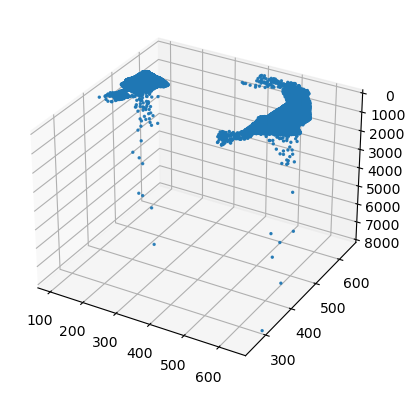

In [15]:
def positions(ts):
    #First, we set up the plot using matplotlib.
    fig = plt.figure()
    threed = fig.add_subplot(projection='3d')

    #We need to create lists in which we will hold the x- and y-coordinates of individuals & the time they were born.
    x, y, t = [], [], []
    
    #Now, we iterate over the individuals in the tree sequence and get their positions & birthdates.
    for ind in ts.individuals():
        #The location attribute of the individual class is an array of the coordinates where the individual is located.
        x_pos = ind.location[0]
        y_pos = ind.location[1]
        time = ind.time
        #Now, we append these values to the lists we created.
        x.append(x_pos)
        y.append(y_pos)
        t.append(time)
    #Time to put it on the plot! First, let's set the z-axis to include all of the generational numbers in our simulation.
    #Because tree sequences count generations backwards, we put the axis in reverse so the final gen is on the top.
    threed.set_zlim([8000,0])
    #So that we can see our data, let's set the size of the points to 2.0. The default size is 10.0.
    threed.scatter3D(x, y, t, s=2.0)

#Let's give our function a go with the simplified tree sequence now:
positions(ts)
#With the %matplotlib widget feature at the very beginning of the code, we can rotate our graph
# & see precisely how individuals are positioned in each generation.

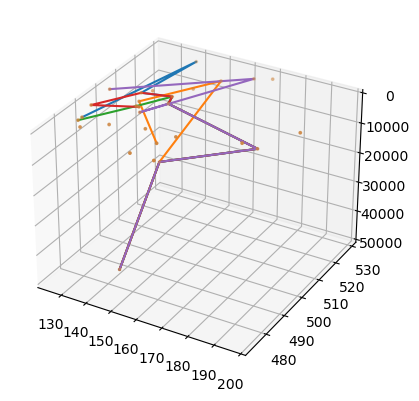

In [16]:
#First, use the 3D plotting code from above:
fig = plt.figure()
threed = fig.add_subplot(projection='3d')

x, y, t = [], [], []

for ind in sts.individuals():

    x_pos = ind.location[0]
    y_pos = ind.location[1]
    time = ind.time

    x.append(x_pos)
    y.append(y_pos)
    t.append(time)

threed.set_zlim([50000,0])
threed.scatter3D(x, y, t, color='peru', s=3)

#Create a list of individuals (random; from present day)
alivelist = [0, 1, 5, 10, 13]
# print(f'aliveliste={alivelist}')
#loop through to make a line of descent for all chosen individuals
for i in alivelist:
    alive_inds = pyslim.individuals_alive_at(sts, 0) #individuals that are alive at the present
    first_node_id = sts.individual(i).nodes[0] #choose the first node in the list of individuals (random choice)
#     print(first_node_id)
#     print(ts.node(first_node_id)) #we can also print out some info on this node

    first_tree = sts.first() #there is only one tree in this ts, so we'll just look at that
    # print(first_tree)
    parray = first_tree.parent_array #parent array (the parent of node i is the ith index of this array) - [12 10 15 11 13
    # 10 11 16 12 16 14 13 15 14 17 17 18 18 -1 -1]

#     print(parray)

    nodes = [] #lets make a list of nodes that are ancestors of our first node
    node = first_node_id #start with the first node

    while node < len(parray) and node > -1: #then, while there exists a parent node
        nodes.append(node) #append it to the list
        node = parray[node] #and then update the current state so that we can find its parent next
        # print(node)

    locs = []
    times = []
#     print(nodes)
#     print([sts.node(node).individual for node in nodes])
    for node in nodes: #now loop through our list of node ids
        # print(node)
        ind_id = sts.node(node).individual #get the individual ids for each
        if ind_id == -1:
            break
        ind = sts.individual(ind_id) #and the individual data
        loc = ind.location #we specifically want the location data
#         print(loc)
        time = ind.time #and the time the individual was alive
        locs.append(loc) #and append the location to a new list of locations
        times.append(time)
#         print((loc, time))

    threed.plot(
        [loc[0] for loc in locs], #the x locations
        [loc[1] for loc in locs], #the y locations
        times #the times
    )

plt.show()

In [17]:
print(pyslim.individuals_alive_at(sts, 0))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


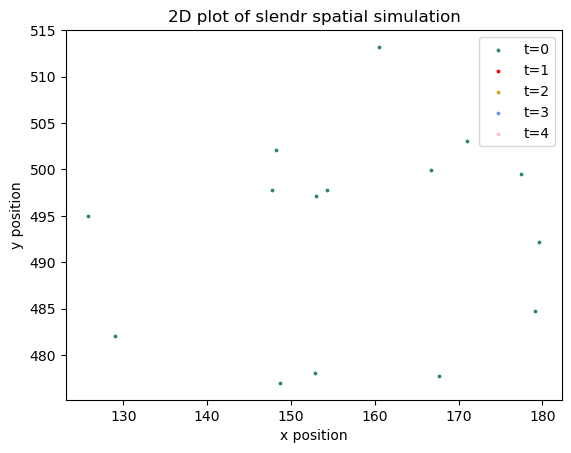

In [18]:
#Using the same 2D plot code from above

slendr_plot = plt.figure()

times = [0, 1, 2, 3, 4] 
colors = ['seagreen','red', 'goldenrod', 'cornflowerblue', 'pink']
#Note: Find the times that match the population sizes we have sampled.
#Colors that match the ones in slendr were chosen for better comparison!

for time, color in zip(times, colors): 
    alive = pyslim.individuals_alive_at(sts, time)
    where = ts.individual_locations[alive] 
    x = where[:,0] 
    y = where[:,1] 
    plt.scatter(x, y, label= 't=%d' %time, color=color, s=3) 

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('2D plot of slendr spatial simulation')
plt.legend() 
plt.show()

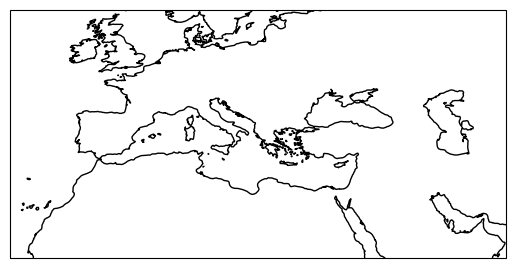

In [19]:
#testing map; import cartopy after installation 
import cartopy.crs as ccrs
figmap = plt.figure()
mapping = figmap.add_subplot(projection=ccrs.PlateCarree())
mapping.coastlines()
mapping.set_xlim(-20, 60) #set x, y limits to make the map match the slendr 2D plot
mapping.set_ylim(20, 60)
plt.show()

R stuff starts here

In [ ]:
ts_df = pd.read_csv("C:/Users/Hp/linuxpc-shared/arabidopsis-test3/data.csv")

In [ ]:
ts_df

In [ ]:
model_metadata <- as.data.frame(readRDS("C:/Users/Hp/linuxpc-shared/arabidopsis-test3/model_metadata.rds"))

In [ ]:
model_metadata

In [ ]:
locations_data <- as.list(model_metadata[c("location", "ind_id")])

In [ ]:
library(jsonlite)
write_json(locations_data, "locations_data.json")

In [ ]:
print(real_locations["78290"])

End of R stuff

In [20]:
import json
with open("locations_data.json") as f:
    locations_data = json.load(f)

In [21]:
locations_data["location"][0:5] # display the first 5 elements of locations_data["location"]

[{'type': 'Point', 'coordinates': [2855246.4879, 1037503.8662]},
 {'type': 'Point', 'coordinates': [2855246.4879, 1037503.8662]},
 {'type': 'Point', 'coordinates': [2956586.1886, 1060524.6945]},
 {'type': 'Point', 'coordinates': [2956586.1886, 1060524.6945]},
 {'type': 'Point', 'coordinates': [3003278.7513, 1158461.6903]}]

In [22]:
locations_data["ind_id"][0:5] # display the first 5 elements of locations_data["ind_id"]

[78290, 78290, 78291, 78291, 78292]

In [23]:
locations_dict = {}
ind_ids = locations_data["ind_id"]
locations = locations_data["location"]
for i in range(len(ind_ids)):
    locations_dict[ind_ids[i]] = locations[i]["coordinates"]

In [24]:
print(locations_dict[42866])

[2971894.66, 2069782.3019]


[0, 27, 21, 20, 18, 17, 16, 15, -1]


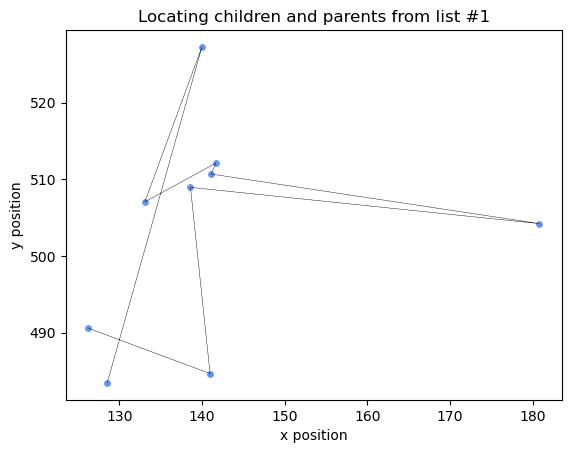

In [25]:
#Plotting a list of child-parents:

#figure3 = plt.figure()
alivelist = [0] #, 1, 3, 7, 9, 12
for ind in alivelist:
    ind_ancestors = dict_of_inds[ind] #Access the first list (index 0) in the list of lists
    print(ind_ancestors)
    loc_an = sts.individual_locations[ind_ancestors] #the locations of individuals from ind_ancestors
#     print(loc_an)

    x = loc_an[:,0] #x, y values
    y = loc_an[:,1] 

    #Introducing more plotting functions:
    plt.plot(x, y, linewidth = 0.3, color = 'black') #add line that connects individuals
    # plt.xlim(0, 9) #Set axes limits to match the scale of the upcoming graph (for better comparison):
    # plt.ylim(0, 9)

    plt.scatter(x, y, color = 'cornflowerblue', s = 15)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locating children and parents from list #1')
plt.show()

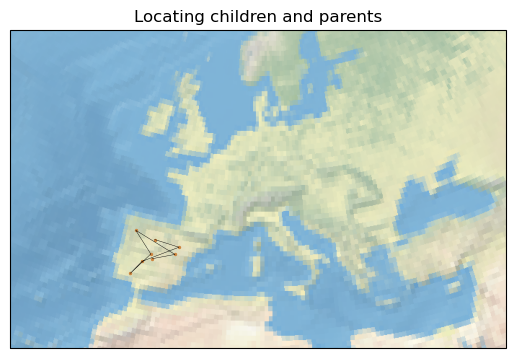

In [26]:
proj = ccrs.epsg(3035)
ax = plt.axes(projection=proj)
ax.stock_img()
ax.set_extent((1500000.0, 7000000.0, -3000000.0, 4500000.0), crs=ccrs.epsg(3035))
# ax.set_xlim(-3500000.0, -2500000.0)
# ax.set_ylim(250000.0, 2600000.0)

# plt.plot(x, y, transform=ccrs.PlateCarree())


alivelist = [0]
for ind in alivelist:
    ind_ancestors = dict_of_inds[ind] #Access the first list (index 0) in the list of lists
    loc_an = []
    for ind in ind_ancestors:
        if ind == -1:
            break
        loc_an.append(locations_dict[ind])
#     loc_an = locations_dict[ind_ancestors] #the locations of individuals from ind_ancestors
#     print(loc_an)

    x = [item[0] for item in loc_an] #x, y values
#     print(x)
    y = [item[1] for item in loc_an]
#     trans_loc = proj.transform_points(ccrs.epsg(3035), x, y)
#     print(trans_loc)
#     new_x = trans_loc[:,0]
#     new_y = trans_loc[:,1]
#     print("x: ", new_x, "y: ", new_y)

    #Introducing more plotting functions:
    plt.plot(x, y, linewidth = 0.3, color = 'black') #add line that connects individuals
#     plt.xlim(-3500000.0, -2500000.0) #Set axes limits to match the scale of the upcoming graph (for better comparison):
#     plt.ylim(250000.0, 2600000.0)

    plt.scatter(x, y, color = 'peru', s = 2)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Locating children and parents')
plt.show()